In [1]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy as sp

In [2]:
plt.style.use('seaborn')

In [3]:
path = './Dataset/test'

img_dict = {}
class_dict = {}
for i,folder in enumerate(os.listdir(path)):
    img = np.random.choice(os.listdir(os.path.join(path,folder)))
    img_dict[folder] = img
    class_dict[i] = folder

print(img_dict,class_dict)

{'Covid': 'ryct.2020200034.fig5-day7.jpeg', 'Normal': 'IM-0349-0001.jpeg'} {0: 'Covid', 1: 'Normal'}


`{'Covid': 'nejmc2001573_f1b.jpeg', 'Normal': 'IM-0389-0001.jpeg'}`

In [4]:
def load_image(img_dict=img_dict):

    covid_path = os.path.join('./Dataset/test/Covid',img_dict['Covid'])
    normal_path = os.path.join('./Dataset/test/Normal',img_dict['Normal'])
    
    covid = image.load_img(covid_path,target_size=(224,224,3))
    covid = image.img_to_array(covid)/255.0
    
    normal = image.load_img(normal_path,target_size=(224,224,3))
    normal = image.img_to_array(normal)/255.0
    
    return covid,normal

In [5]:
covid_img,normal_img = load_image(img_dict)

In [6]:
img_data = []
img_data.append(covid_img)
img_data.append(normal_img)

img_data = np.asarray(img_data,dtype='float')
img_data.shape

(2, 224, 224, 3)

### Plot Image

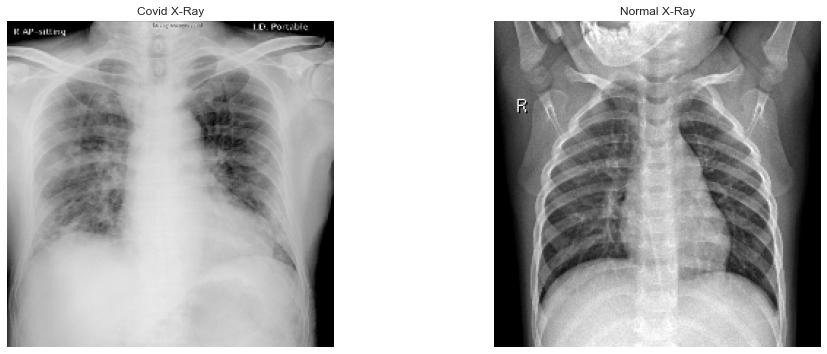

In [7]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

ax[0].imshow(covid_img)
ax[0].set_title('Covid X-Ray')
ax[0].axis('off')

ax[1].imshow(normal_img)
ax[1].set_title('Normal X-Ray')
ax[1].axis('off')

plt.show()

### Load Model

In [8]:
path = './Weights/Scratch/model_6_1.00.h5'

In [9]:
from keras.models import load_model
from keras.models import Model

model = load_model(path)

In [10]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(64, 2)

In [11]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-9].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0     

In [12]:
features,results = cam_model.predict(img_data)
features.shape

(2, 54, 54, 64)

In [13]:
results

array([[0.972152  , 0.027848  ],
       [0.00393237, 0.99606764]], dtype=float32)

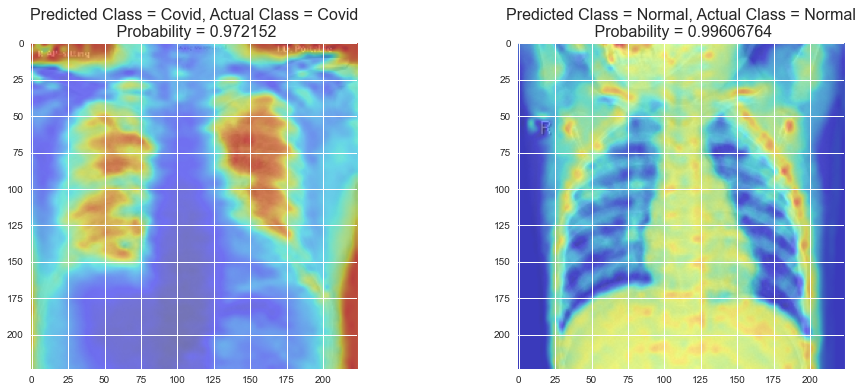

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

for i in range(2):
    features_for_one_img = features[i,:,:,:]
    height_roomout = img_data.shape[1]/features_for_one_img.shape[0]
    width_roomout  = img_data.shape[2]/features_for_one_img.shape[1]

    cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    pred = np.argmax(results[i])
    
    cam_weights = gap_weights[:,pred]
    cam_output  = np.dot(cam_features,cam_weights)
    
    buf = 'Predicted Class = ' +str( class_dict[pred] )+ ', Actual Class = ' +str(class_dict[i])+'\n Probability = ' + str(results[i][pred])
    
    ax[i].imshow(np.squeeze(img_data[i]), alpha=0.5)
    ax[i].imshow(cam_output, cmap='jet', alpha=0.5)
    ax[i].set_title(buf,fontsize=16)
     
plt.show()

In [15]:
if not os.path.exists('./Class Activation Images'):
    os.mkdir('./Class Activation Images')
    print('Directory created')
else:
    print('Already Created')

Already Created


In [16]:
fig.savefig(f'./Class Activation Images/scratch_activation_{results[0][0]:.3f}_{results[1][1]:.3f}.png')